### Import required libraries and read data

In [ ]:
# !pip install scikit-optimize


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import polars as pl
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.model_selection import GridSearchCV


from skopt import gp_minimize
from skopt.space import Real

from sklearn.gaussian_process.kernels import Matern, ExpSineSquared
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def feature_eng(df_data, df_client, df_gas, df_electricity, df_forecast, df_location, df_target):
    df_data = (
        df_data
        .join(df_target, on=["county", "is_business", "product_type", "is_consumption", "datetime"], how="left")
    )

    df_consume = (
        df_data
        .filter(pl.col("is_consumption").eq(1))
        .select("target", "county", "is_business", "product_type", "datetime")
    )

    df_data = (
        df_data
        .filter(pl.col("is_consumption").eq(0))
        .join(df_consume, on=["county", "is_business", "product_type", "datetime"], how="left")
        .rename({"target": "production", "target_right": "consumption"})
        .with_columns(pl.col("datetime").cast(pl.Date).alias("date"))
        .drop("is_consumption")
    )

    df_client = (
        df_client
        .with_columns((pl.col("date") + pl.duration(days=2)).cast(pl.Date))
    )

    df_gas = (
        df_gas
        .rename({"forecast_date": "date"})
        .with_columns((pl.col("date") + pl.duration(days=1)).cast(pl.Date))
    )

    df_electricity = (
        df_electricity
        .rename({"forecast_date": "datetime"})
        .with_columns(datetime=pl.col("datetime") + pl.duration(days=1))
    )

    df_location = (
        df_location
        .with_columns(
            pl.col("latitude").cast(pl.datatypes.Float32),
            pl.col("longitude").cast(pl.datatypes.Float32)
        )
    )

    df_forecast = (
        df_forecast
        .rename({"forecast_datetime": "datetime"})
        .with_columns(
            pl.col("latitude").cast(pl.datatypes.Float32),
            pl.col("longitude").cast(pl.datatypes.Float32),
        )
        .join(df_location, how="left", on=["longitude", "latitude"])
        .drop("longitude", "latitude")
        .with_columns(pl.col("county").fill_nan(12))
        .group_by("county", "datetime").mean()
    )

    df_data = (
        df_data
        .join(df_gas, on="date", how="left")
        .join(df_client, on=["county", "is_business", "product_type", "date"], how="left")
        .join(df_electricity, on="datetime", how="left")
        .join(df_forecast, on=["county", "datetime"], how="left")
        .with_columns(
            pl.col(pl.Float64).cast(pl.Float32),
        )
        .drop("date")
    )

    return df_data

In [ ]:

def to_pandas(df):
    df = df.to_pandas()
    df = df.set_index("row_id")

    return df

In [ ]:
data_cols        = ['target', 'county', 'is_business', 'product_type', 'is_consumption', 'datetime', 'row_id','prediction_unit_id']
client_cols      = ['product_type', 'county', 'eic_count', 'installed_capacity', 'is_business', 'date']
gas_cols         = ['forecast_date', 'lowest_price_per_mwh', 'highest_price_per_mwh']
electricity_cols = ['forecast_date', 'euros_per_mwh']
forecast_cols    = ['latitude', 'longitude', 'temperature', 'dewpoint', 'cloudcover_high', 'cloudcover_low', 'cloudcover_mid', 'cloudcover_total', '10_metre_u_wind_component', '10_metre_v_wind_component', 'forecast_datetime', 'direct_solar_radiation', 'surface_solar_radiation_downwards', 'snowfall', 'total_precipitation']
location_cols    = ['longitude', 'latitude', 'county']
target_cols      = ['county', 'is_business', 'product_type', 'target', 'is_consumption', 'datetime']

In [ ]:
df_data        = pl.read_csv('/content/drive/MyDrive/College/AML/train.csv', columns=data_cols, try_parse_dates=True)
df_client      = pl.read_csv('/content/drive/MyDrive/College/AML/client.csv', columns=client_cols, try_parse_dates=True)
df_gas         = pl.read_csv('/content/drive/MyDrive/College/AML/gas_prices.csv', columns=gas_cols, try_parse_dates=True)
df_electricity = pl.read_csv('/content/drive/MyDrive/College/AML/electricity_prices.csv', columns=electricity_cols, try_parse_dates=True)
df_forecast    = pl.read_csv('/content/drive/MyDrive/College/AML/forecast_weather.csv', columns=forecast_cols, try_parse_dates=True)
df_location    = pl.read_csv('/content/drive/MyDrive/College/AML/weather_station_to_county_mapping.csv', columns=location_cols, try_parse_dates=True)

df_target      = df_data.select(target_cols)
df_data        = df_data.drop("target")

df_data        = df_data.filter(pl.col("datetime").lt(pd.Timestamp("20230528")))
df_client      = df_client.filter(pl.col("date").lt(pd.Timestamp("20230526")))
df_gas         = df_gas.filter(pl.col("forecast_date").lt(pd.Timestamp("20230527")))
df_electricity = df_electricity.filter(pl.col("forecast_date").lt(pd.Timestamp("20230527")))
df_target      = df_target.filter(pl.col("datetime").lt(pd.Timestamp("20230526")))

schema_data        = df_data.schema
schema_client      = df_client.schema
schema_gas         = df_gas.schema
schema_electricity = df_electricity.schema
schema_forecast    = df_forecast.schema
schema_target      = df_target.schema

In [ ]:
df_data.columns

['county',
 'is_business',
 'product_type',
 'is_consumption',
 'datetime',
 'row_id',
 'prediction_unit_id']

### Data Preprocessing

In [ ]:
print(df_data.columns)
df_train = feature_eng(df_data, df_client, df_gas, df_electricity, df_forecast, df_location, df_target)
df_train = to_pandas(df_train)

df_train = df_train[df_train["consumption"].notnull()]
df_train = df_train[df_train["production"].notnull()]

['county', 'is_business', 'product_type', 'is_consumption', 'datetime', 'row_id', 'prediction_unit_id']


In [ ]:
df_train.isnull().sum()

,0
county,0
is_business,0
product_type,0
datetime,0
prediction_unit_id,0
production,0
consumption,0
lowest_price_per_mwh,1464
highest_price_per_mwh,1464
eic_count,4320


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 999504 entries, 0 to 1999534
Data columns (total 24 columns):
 #   Column                             Non-Null Count   Dtype         
---  ------                             --------------   -----         
 0   county                             999504 non-null  int64         
 1   is_business                        999504 non-null  int64         
 2   product_type                       999504 non-null  int64         
 3   datetime                           999504 non-null  datetime64[us]
 4   prediction_unit_id                 999504 non-null  int64         
 5   production                         999504 non-null  float32       
 6   consumption                        999504 non-null  float32       
 7   lowest_price_per_mwh               998040 non-null  float32       
 8   highest_price_per_mwh              998040 non-null  float32       
 9   eic_count                          995184 non-null  float64       
 10  installed_capacity      

In [ ]:
# Drop rows where any column has null value
df_non_nan = df_train.dropna()
df_non_nan = df_non_nan.copy()
df_non_nan.loc[:, 'day'] = df_non_nan['datetime'].dt.day
df_non_nan.loc[:, 'month'] = df_non_nan['datetime'].dt.month
df_non_nan.loc[:, 'year'] = df_non_nan['datetime'].dt.year
df_non_nan.loc[:, 'hour'] = df_non_nan['datetime'].dt.hour

In [ ]:
df_non_nan[['county','is_business','product_type','year','month','day']] = df_non_nan[['county','is_business','product_type','year','month','day']].astype('str')

In [ ]:
df_non_nan.info()

<class 'pandas.core.frame.DataFrame'>
Index: 979937 entries, 5856 to 1999534
Data columns (total 28 columns):
 #   Column                             Non-Null Count   Dtype         
---  ------                             --------------   -----         
 0   county                             979937 non-null  object        
 1   is_business                        979937 non-null  object        
 2   product_type                       979937 non-null  object        
 3   datetime                           979937 non-null  datetime64[us]
 4   prediction_unit_id                 979937 non-null  int64         
 5   production                         979937 non-null  float32       
 6   consumption                        979937 non-null  float32       
 7   lowest_price_per_mwh               979937 non-null  float32       
 8   highest_price_per_mwh              979937 non-null  float32       
 9   eic_count                          979937 non-null  float64       
 10  installed_capacity   

### EDA

In [ ]:
df_non_nan.columns

Index(['county', 'is_business', 'product_type', 'datetime',
       'prediction_unit_id', 'production', 'consumption',
       'lowest_price_per_mwh', 'highest_price_per_mwh', 'eic_count',
       'installed_capacity', 'euros_per_mwh', 'temperature', 'dewpoint',
       'cloudcover_high', 'cloudcover_low', 'cloudcover_mid',
       'cloudcover_total', '10_metre_u_wind_component',
       '10_metre_v_wind_component', 'direct_solar_radiation',
       'surface_solar_radiation_downwards', 'snowfall', 'total_precipitation',
       'day', 'month', 'year', 'hour'],
      dtype='object')

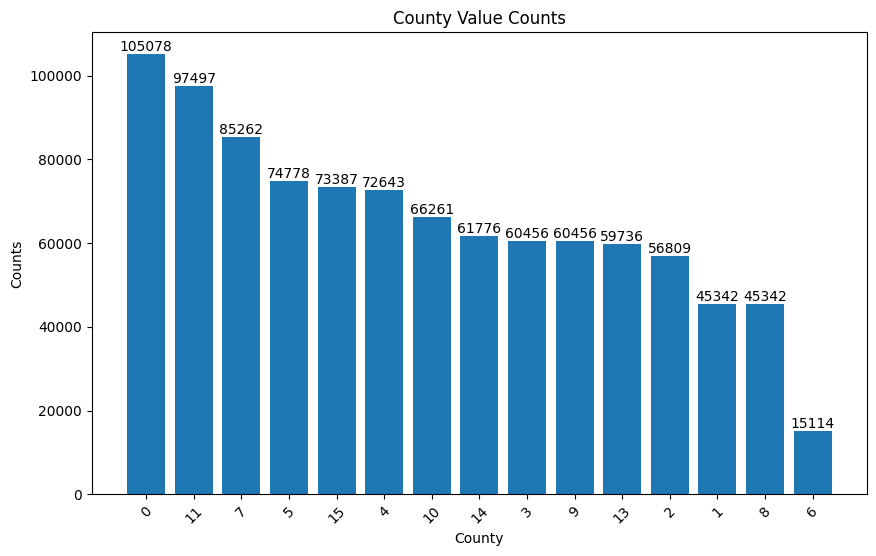

In [ ]:
value_counts = df_non_nan['county'].value_counts()

plt.figure(figsize=(10, 6))
bars = plt.bar(value_counts.index, value_counts.values)
plt.title('County Value Counts')
plt.xlabel('County')
plt.ylabel('Counts')
plt.xticks(rotation=45)

# Adding the value annotations on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom')

plt.show()

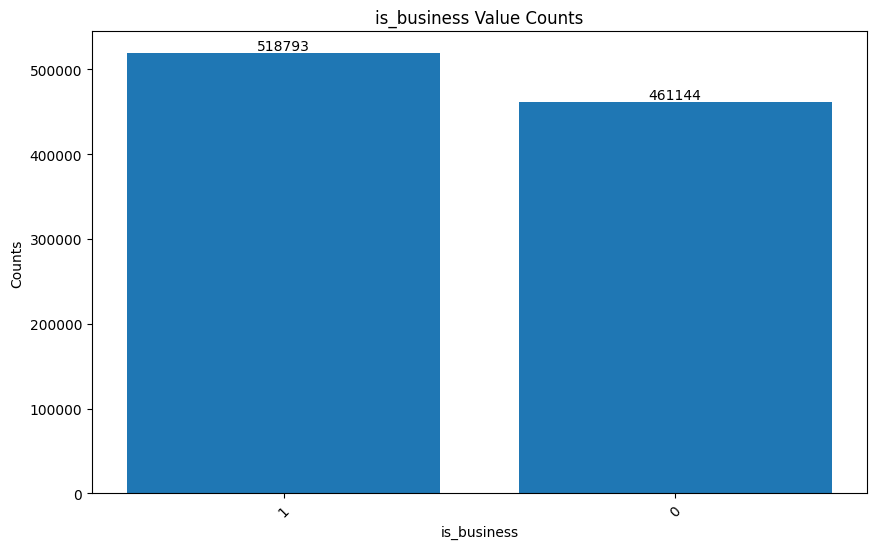

In [ ]:
value_counts = df_non_nan['is_business'].value_counts()
plt.figure(figsize=(10, 6))
bars = plt.bar(value_counts.index, value_counts.values)
plt.title('is_business Value Counts')
plt.xlabel('is_business')
plt.ylabel('Counts')
plt.xticks(rotation=45)

# Adding the value annotations on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom')

plt.show()

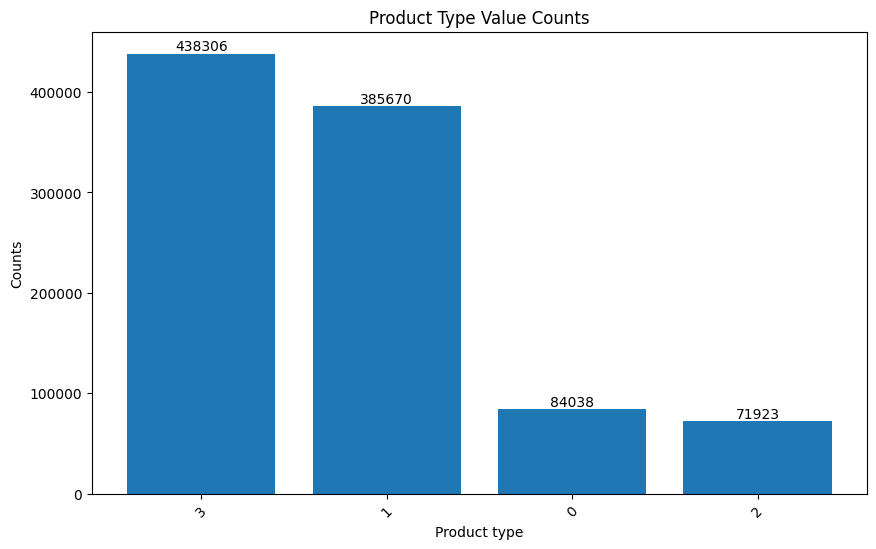

In [ ]:
value_counts = df_non_nan['product_type'].value_counts()
plt.figure(figsize=(10, 6))
bars = plt.bar(value_counts.index, value_counts.values)
plt.title('Product Type Value Counts')
plt.xlabel('Product type')
plt.ylabel('Counts')
plt.xticks(rotation=45)

# Adding the value annotations on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom')

plt.show()

In [ ]:
df_non_nan[['production','consumption','lowest_price_per_mwh','highest_price_per_mwh','eic_count','installed_capacity', 'euros_per_mwh', 'temperature', 'dewpoint',
       'cloudcover_high', 'cloudcover_low', 'cloudcover_mid',
       'cloudcover_total', '10_metre_u_wind_component',
       '10_metre_v_wind_component', 'direct_solar_radiation',
       'surface_solar_radiation_downwards', 'snowfall', 'total_precipitation']].describe()

,production,consumption,lowest_price_per_mwh,highest_price_per_mwh,eic_count,installed_capacity,euros_per_mwh,temperature,dewpoint,cloudcover_high,cloudcover_low,cloudcover_mid,cloudcover_total,10_metre_u_wind_component,10_metre_v_wind_component,direct_solar_radiation,surface_solar_radiation_downwards,snowfall,total_precipitation
count,979937.000000,979937.000000,979937.000000,979937.000000,979937.000000,979937.000000,979937.000000,979937.000000,979937.000000,979937.000000,979937.000000,979937.000000,979937.000000,979937.000000,979937.000000,979937.000000,979937.000000,979937.000000,979937.000000
mean,87.117584,461.258301,96.210182,109.137283,74.010154,1461.111328,158.550400,5.244806,1.775155,0.399530,0.457949,0.369468,0.699225,0.995255,0.730992,141.906174,107.032959,0.000027,0.000079
std,372.512543,1210.704834,47.356659,54.540627,144.111933,2422.834229,121.501884,8.401690,7.357531,0.403836,0.410318,0.384662,0.360584,2.943973,3.096826,239.078979,180.442261,0.000110,0.000221
min,0.000000,0.000000,33.560001,35.400002,5.000000,6.000000,-1.110000,-23.578251,-25.808439,0.000000,0.000000,0.000000,0.000000,-9.588291,-14.274986,-0.419028,-0.193056,-0.000002,-0.000008
25%,0.000000,34.151001,62.500000,67.820000,14.000000,324.000000,85.739998,-0.809658,-3.272091,0.000000,0.026775,0.002904,0.405174,-1.210157,-1.423024,0.000000,0.000000,0.000000,0.000000
50%,0.351000,105.939003,86.000000,95.500000,32.000000,657.000000,129.949997,4.582910,1.344100,0.257689,0.363281,0.211967,0.902827,1.225617,0.881052,0.017778,0.569210,0.000000,0.000004
75%,24.069000,369.351013,110.000000,133.839996,71.000000,1574.900024,200.009995,10.911020,6.813135,0.851368,0.948593,0.746991,0.999989,3.062344,2.926785,204.162170,142.238724,0.000002,0.000047
max,11209.013672,15480.274414,250.000000,305.000000,1515.000000,19297.810547,4000.000000,31.282862,20.870020,1.000007,1.000008,1.000007,1.000007,13.059646,12.251591,914.069153,828.969238,0.002708,0.009638


from matplotlib import pyplot as plt
_df_0['production'].plot(kind='hist', bins=20, title='production')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['consumption'].plot(kind='hist', bins=20, title='consumption')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['lowest_price_per_mwh'].plot(kind='hist', bins=20, title='lowest_price_per_mwh')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['highest_price_per_mwh'].plot(kind='hist', bins=20, title='highest_price_per_mwh')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='production', y='consumption', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='consumption', y='lowest_price_per_mwh', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='lowest_price_per_mwh', y='highest_price_per_mwh', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='highest_price_per_mwh', y='eic_count', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_8['production'].plot(kind='line', figsize=(8, 4), title='production')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_9['consumption'].plot(kind='line', figsize=(8, 4), title='consumption')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_10['lowest_price_per_mwh'].plot(kind='line', figsize=(8, 4), title='lowest_price_per_mwh')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_11['highest_price_per_mwh'].plot(kind='line', figsize=(8, 4), title='highest_price_per_mwh')
plt.gca().spines[['top', 'right']].set_visible(False)

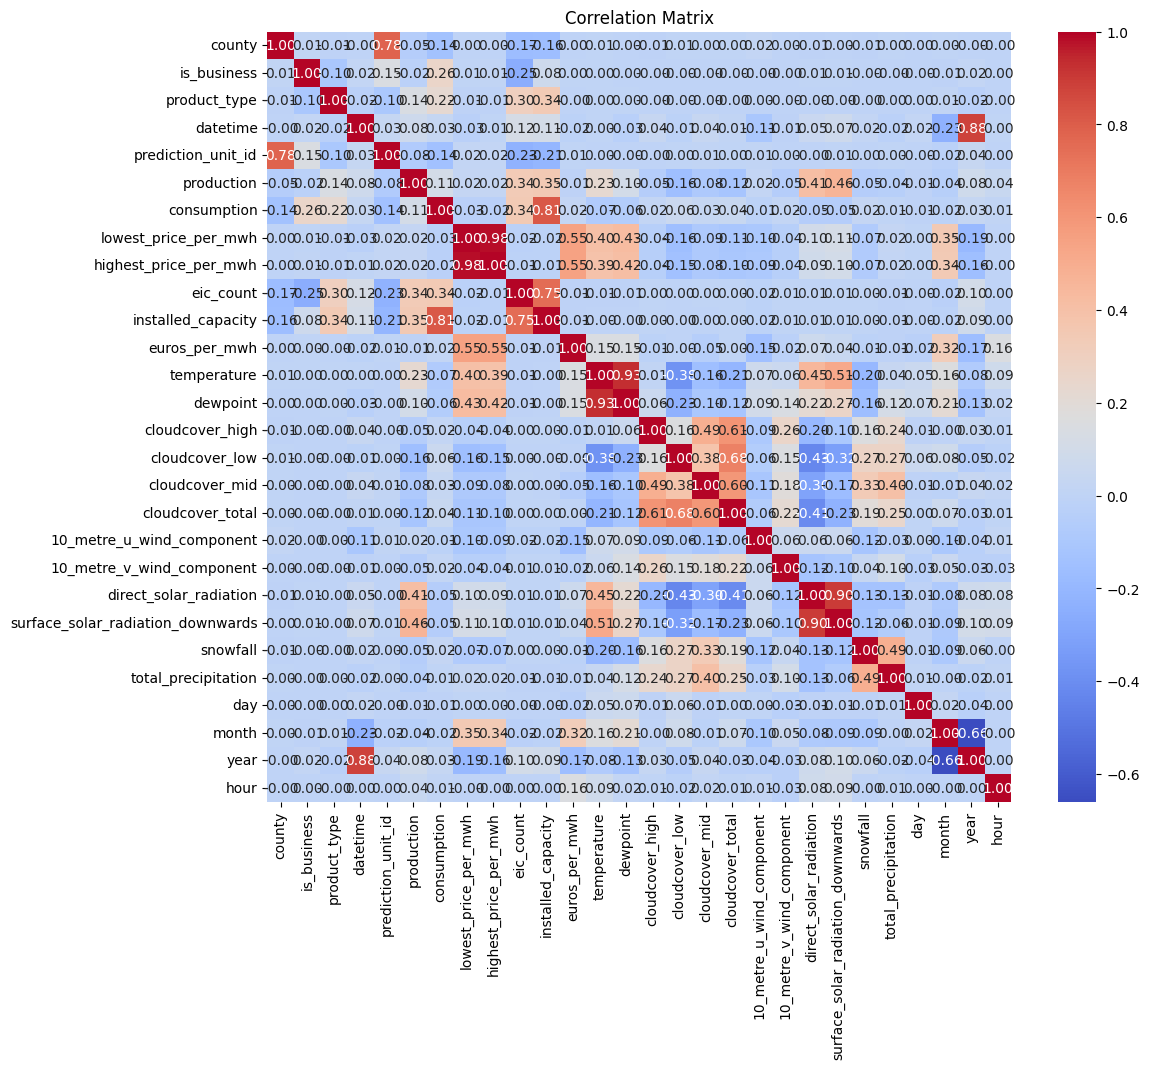

In [ ]:
# Correlation matrix
correlation_matrix = df_non_nan.corr()

# Heatmap for correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


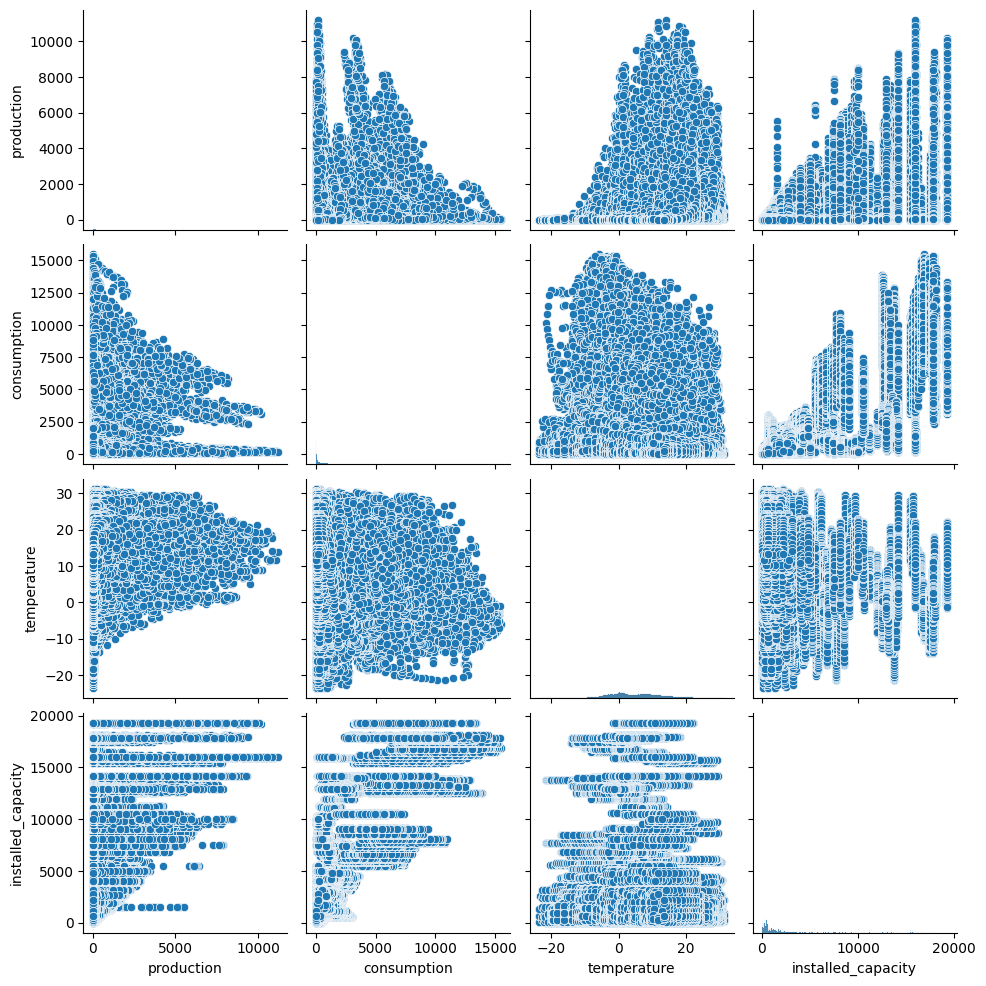

In [ ]:
sns.pairplot(df_non_nan[['production', 'consumption', 'temperature', 'installed_capacity']])
plt.show()


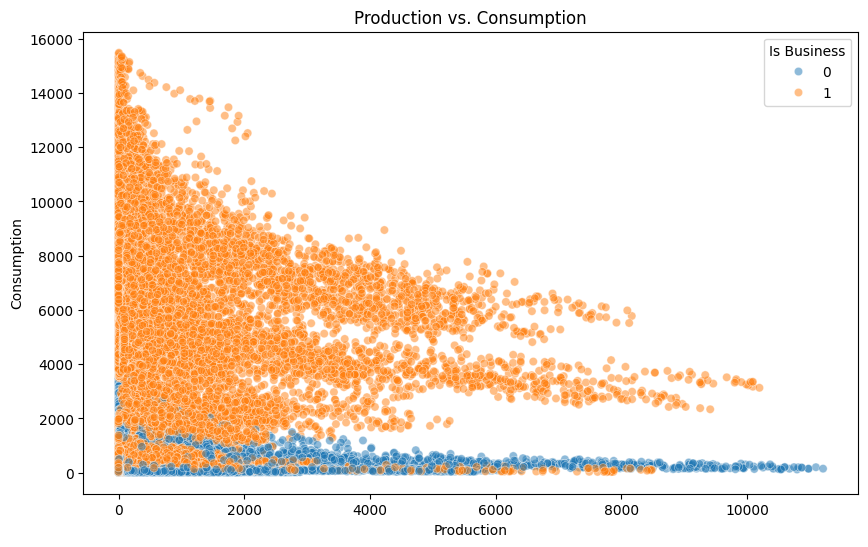

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_non_nan, x='production', y='consumption', hue='is_business', alpha=0.5)
plt.title('Production vs. Consumption')
plt.xlabel('Production')
plt.ylabel('Consumption')
plt.legend(title='Is Business')
plt.show()


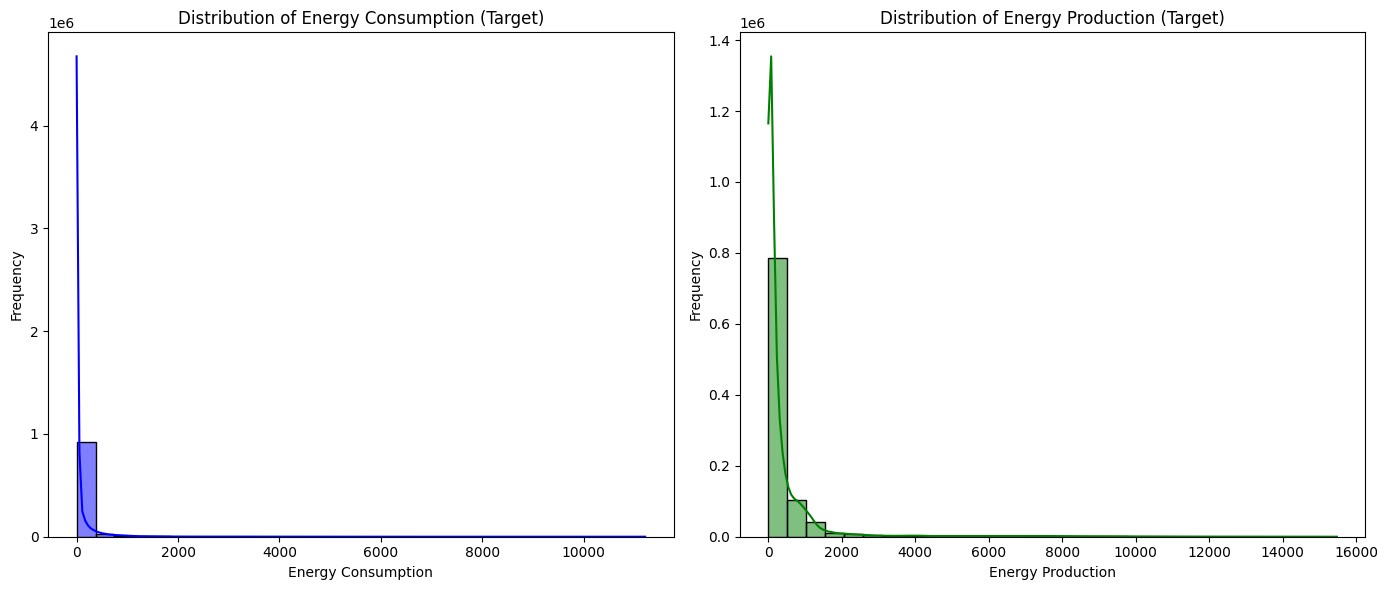

In [ ]:
plt.figure(figsize=(14, 6))
# Distribution of consumption
plt.subplot(1, 2, 1)
sns.histplot(df_non_nan['production'], kde=True, bins=30, color='blue')
plt.title('Distribution of Energy Consumption (Target)')
plt.xlabel('Energy Consumption')
plt.ylabel('Frequency')

# Distribution of production
plt.subplot(1, 2, 2)
sns.histplot(df_non_nan['consumption'], kde=True, bins=30, color='green')
plt.title('Distribution of Energy Production (Target)')
plt.xlabel('Energy Production')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

From this figure, it is  visibl that both energy consumption and production are highly right-skewed, indicating that most of the observations are at lower levels of consumption or production.There are a few extreme outliers in both cases, but they occur at very low frequencies.

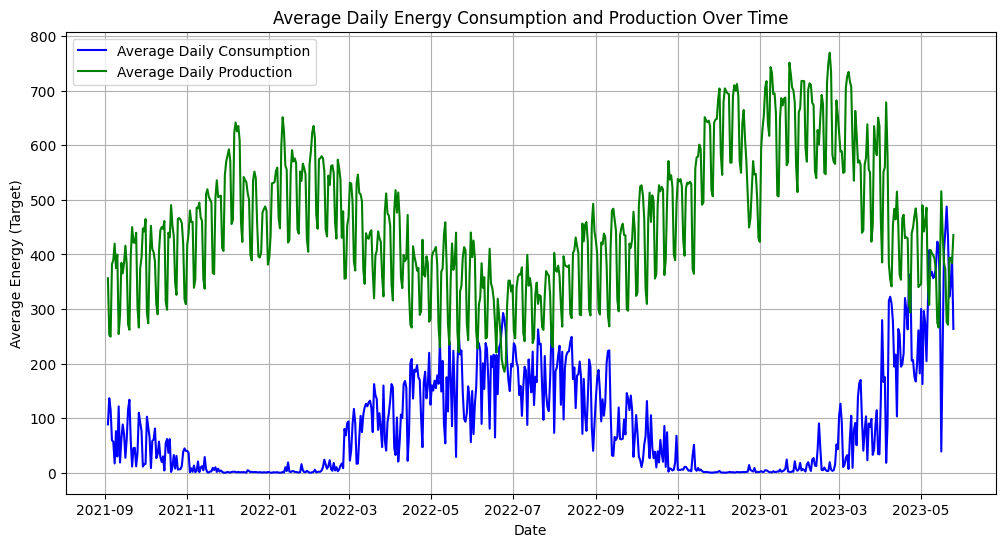

In [ ]:
# Group by date and calculate the mean target (energy) for each day
daily_avg_consumption = df_non_nan.resample('D', on='datetime')['production'].mean()
daily_avg_production = df_non_nan.resample('D', on='datetime')['consumption'].mean()

# Plotting
plt.figure(figsize=(12, 6))

plt.plot(daily_avg_consumption, label='Average Daily Consumption', color='blue')
plt.plot(daily_avg_production, label='Average Daily Production', color='green')

plt.xlabel('Date')
plt.ylabel('Average Energy (Target)')
plt.title('Average Daily Energy Consumption and Production Over Time')
plt.legend()
plt.grid(True)
plt.show()

<Axes: xlabel='county', ylabel='Count'>

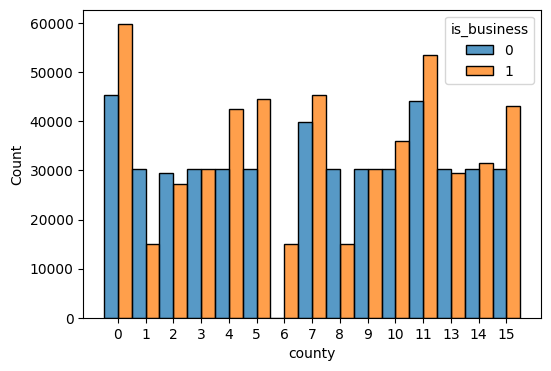

In [ ]:
## categorical feature
plt.figure(figsize=(13,4))
plt.subplot(121)
sns.histplot(x=df_non_nan.county, hue=df_non_nan.is_business, multiple='dodge')

<Axes: xlabel='product_type', ylabel='Count'>

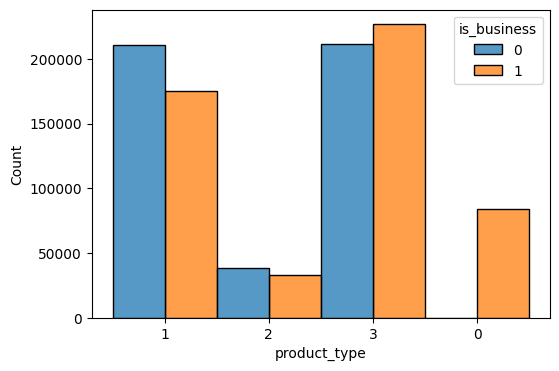

In [ ]:
## categorical feature
plt.figure(figsize=(13,4))
plt.subplot(121)
sns.histplot(x=df_non_nan.product_type, hue=df_non_nan.is_business, multiple='dodge')

In [ ]:
enefit = pd.read_csv('/content/drive/MyDrive/College/AML/train.csv')
enefit["datetime"] = pd.to_datetime(enefit["datetime"])

consumption = enefit[enefit["is_consumption"]==1]
monthlyCons = consumption.groupby(pd.Grouper(key="datetime", freq='M')).mean()
weeklyCons = consumption.groupby(pd.Grouper(key="datetime", freq='W')).mean()
dailyCons = consumption.groupby(pd.Grouper(key="datetime", freq='D')).mean()
meanConsumption = consumption.target.mean()

production = enefit[enefit["is_consumption"]==0]
monthlyProd = production.groupby(pd.Grouper(key="datetime", freq='M')).mean()
weeklyProd = production.groupby(pd.Grouper(key="datetime", freq='W')).mean()
dailyProd = production.groupby(pd.Grouper(key="datetime", freq='D')).mean()
meanProduction = production.target.mean()

business = enefit.query("is_business == 1 & is_consumption == 1")
businessMonthlyCons = business.groupby(pd.Grouper(key="datetime", freq='M')).mean()
businessWeeklyCons = business.groupby(pd.Grouper(key="datetime", freq='W')).mean()
businessDailyCons = business.groupby(pd.Grouper(key="datetime", freq='D')).mean()
meanBusiness = business.target.mean()

<ipython-input-28-77093d54d06e>:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthlyCons = consumption.groupby(pd.Grouper(key="datetime", freq='M')).mean()
<ipython-input-28-77093d54d06e>:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthlyProd = production.groupby(pd.Grouper(key="datetime", freq='M')).mean()
<ipython-input-28-77093d54d06e>:17: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  businessMonthlyCons = business.groupby(pd.Grouper(key="datetime", freq='M')).mean()


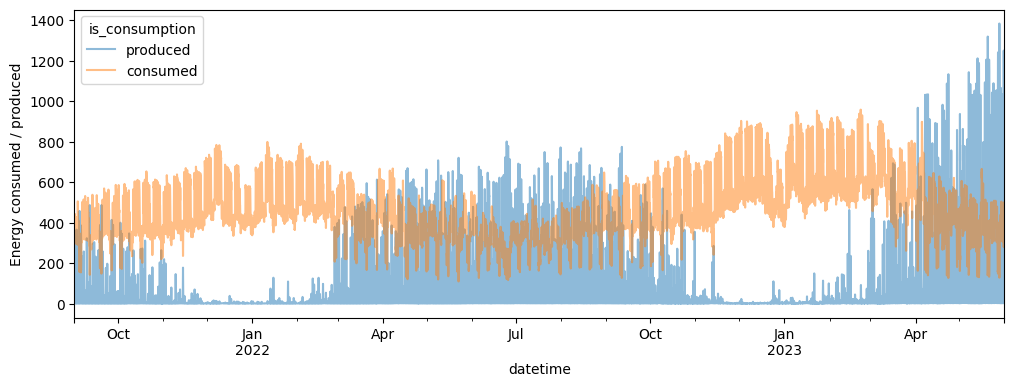

In [ ]:
train_avgd = (
    enefit
    .groupby(['datetime','is_consumption'])
    ['target'].mean()
    .unstack()
    .rename({0: 'produced', 1:'consumed'}, axis=1)
)

fig, ax = plt.subplots(1, 1, figsize=(12, 4))
_ = train_avgd.plot(ax=ax, alpha=0.5)
_ = ax.set_ylabel('Energy consumed / produced')

In [ ]:
import plotly as py
import plotly.express as px
import plotly.graph_objs as go
from plotly import tools
from plotly.subplots import make_subplots
fig = px.area(dailyCons,x=dailyCons.index,y="target",
              title='1. Daily Consumption Analysis')
fig.add_hline(y=meanConsumption, line_dash="dot",
              annotation_text="Average Consumption",
              annotation_position="bottom right")
fig.update_traces(line_color='#FA163F')
fig.update_layout(xaxis_title="Date",
                  yaxis_title="Consumption")
fig.show()


In [ ]:
fig = px.area(dailyProd,x=dailyProd.index,y="target",
              title='2. Daily Production Analysis')
fig.add_hline(y=meanProduction, line_dash="dot",
              annotation_text="Average Production",
              annotation_position="bottom right")
fig.update_traces(line_color='#427D9D')
fig.update_layout(xaxis_title="Date",
                  yaxis_title="Production")
fig.show()

In [ ]:
fig = px.area(dailyCons["target"]-dailyProd["target"],
              x=dailyProd.index,y="target",
              title='3. Daily Net Consumption (Consumption-Production) Analysis')
fig.add_hline(y=(dailyCons["target"]-dailyProd["target"]).mean(),
              line_dash="dot", annotation_text="Average Net Consumption",
              annotation_position="bottom right")
fig.update_traces(line_color='#EC8F5E')
fig.update_layout(xaxis_title="Date", yaxis_title="Net Consumption")
fig.show()

In [ ]:
fig = px.area(businessDailyCons,x=businessDailyCons.index,y="target",
              title='4. Daily Consumption of Businesses',
              line_shape='spline')
fig.add_hline(y=meanBusiness, line_dash="dot",
              annotation_text="Average Consumption",
              annotation_position="top right")
fig.update_traces(line_color='#025DAD')
fig.update_layout(xaxis_title="Date",
                  yaxis_title="Consumption")
fig.show()

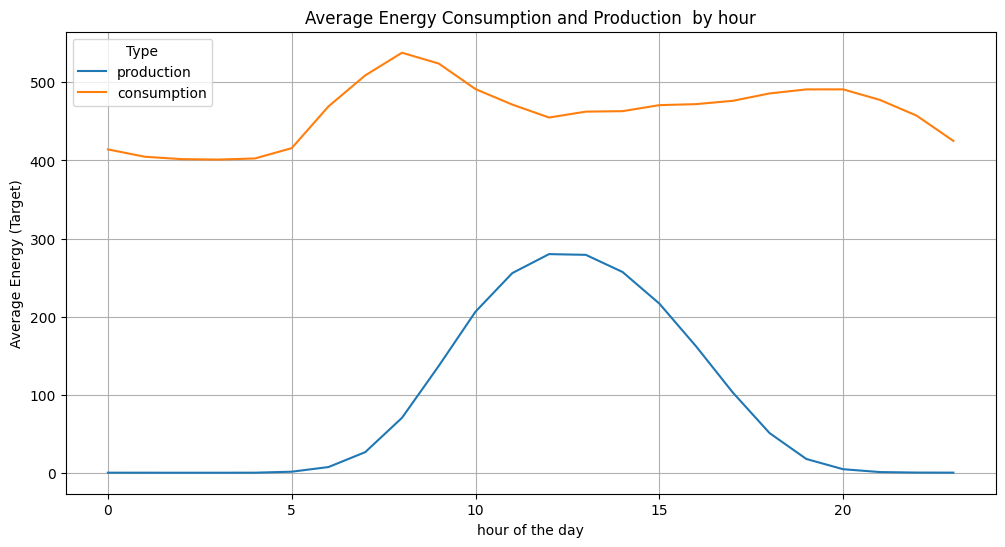

In [ ]:

df_melted = df_non_nan.melt(id_vars=['hour'],
                          value_vars=['production', 'consumption'],
                          var_name='Type',
                          value_name='target')

# Plotting the lineplot
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_melted, x='hour', y='target', hue='Type', errorbar=None)
plt.title('Average Energy Consumption and Production  by hour')
plt.xlabel('hour of the day')
plt.ylabel('Average Energy (Target)')
plt.legend(title='Type')
plt.grid(True)
plt.show()


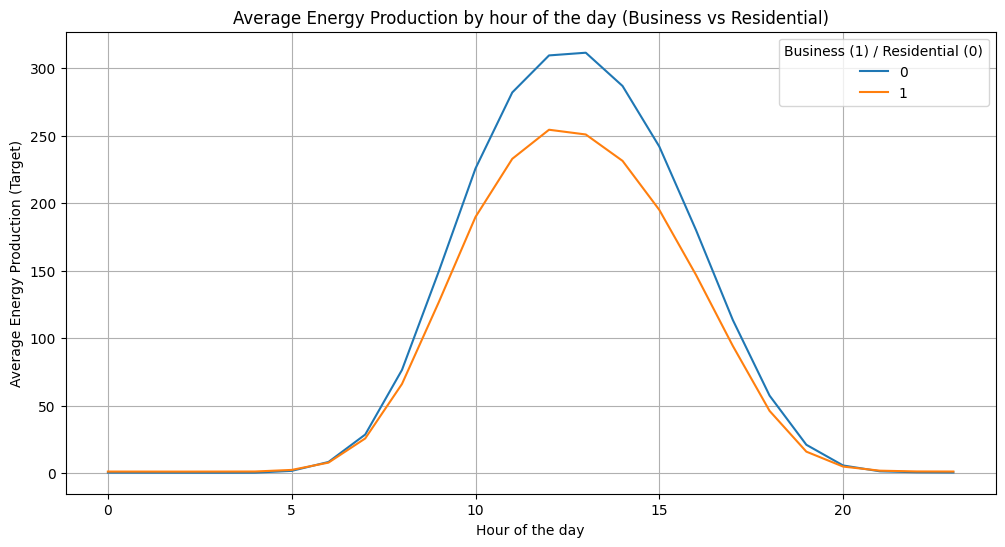

In [ ]:


plt.figure(figsize=(12, 6))
sns.lineplot(data=df_non_nan, x='hour', y='production', hue='is_business', errorbar=None)
plt.title('Average Energy Production by hour of the day (Business vs Residential)')
plt.xlabel('Hour of the day')
plt.ylabel('Average Energy Production (Target)')
plt.legend(title='Business (1) / Residential (0)')
plt.grid(True)
plt.show()

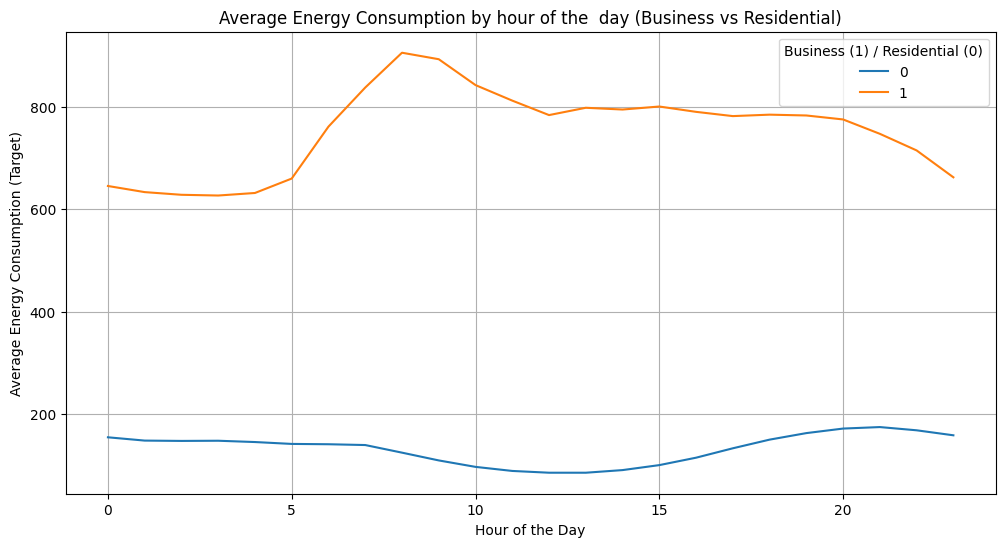

In [ ]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_non_nan, x='hour', y='consumption', hue='is_business', errorbar=None)
plt.title('Average Energy Consumption by hour of the  day (Business vs Residential)')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Energy Consumption (Target)')
plt.legend(title='Business (1) / Residential (0)')
plt.grid(True)
plt.show()

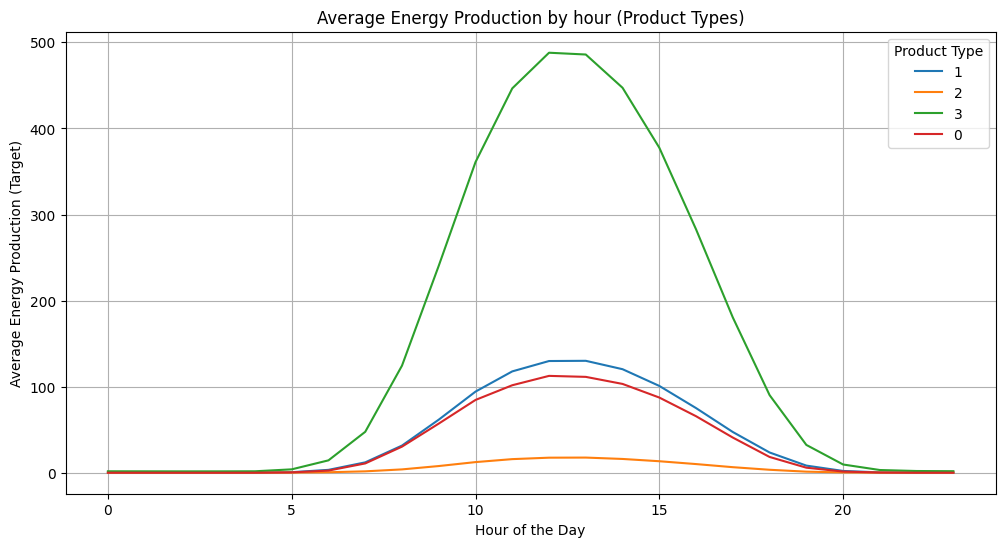

In [ ]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_non_nan, x='hour', y='production', hue='product_type', errorbar=None)
plt.title('Average Energy Production by hour (Product Types)')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Energy Production (Target)')
plt.legend(title='Product Type')
plt.grid(True)
plt.show()

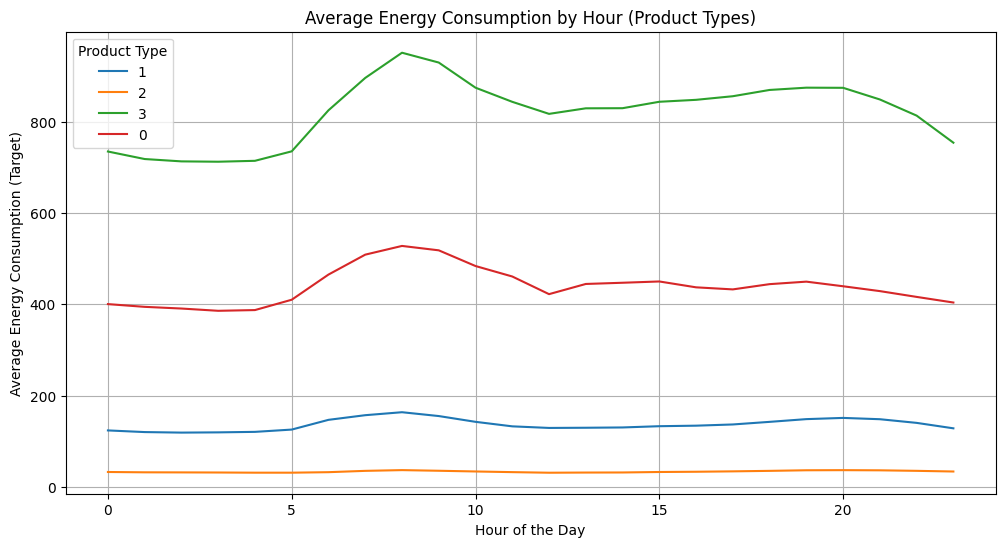

In [ ]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_non_nan, x='hour', y='consumption', hue='product_type', errorbar=None)
plt.title('Average Energy Consumption by Hour (Product Types)')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Energy Consumption (Target)')
plt.legend(title='Product Type')
plt.grid(True)
plt.show()


### Check outliers

In [ ]:
numeric_columns = ['production', 'consumption', 'lowest_price_per_mwh',
                   'highest_price_per_mwh', 'eic_count', 'installed_capacity',
                   'euros_per_mwh', 'temperature', 'dewpoint', 'cloudcover_high',
                   'cloudcover_low', 'cloudcover_mid', 'cloudcover_total',
                   '10_metre_u_wind_component', '10_metre_v_wind_component',
                   'direct_solar_radiation', 'surface_solar_radiation_downwards',
                   'snowfall', 'total_precipitation']

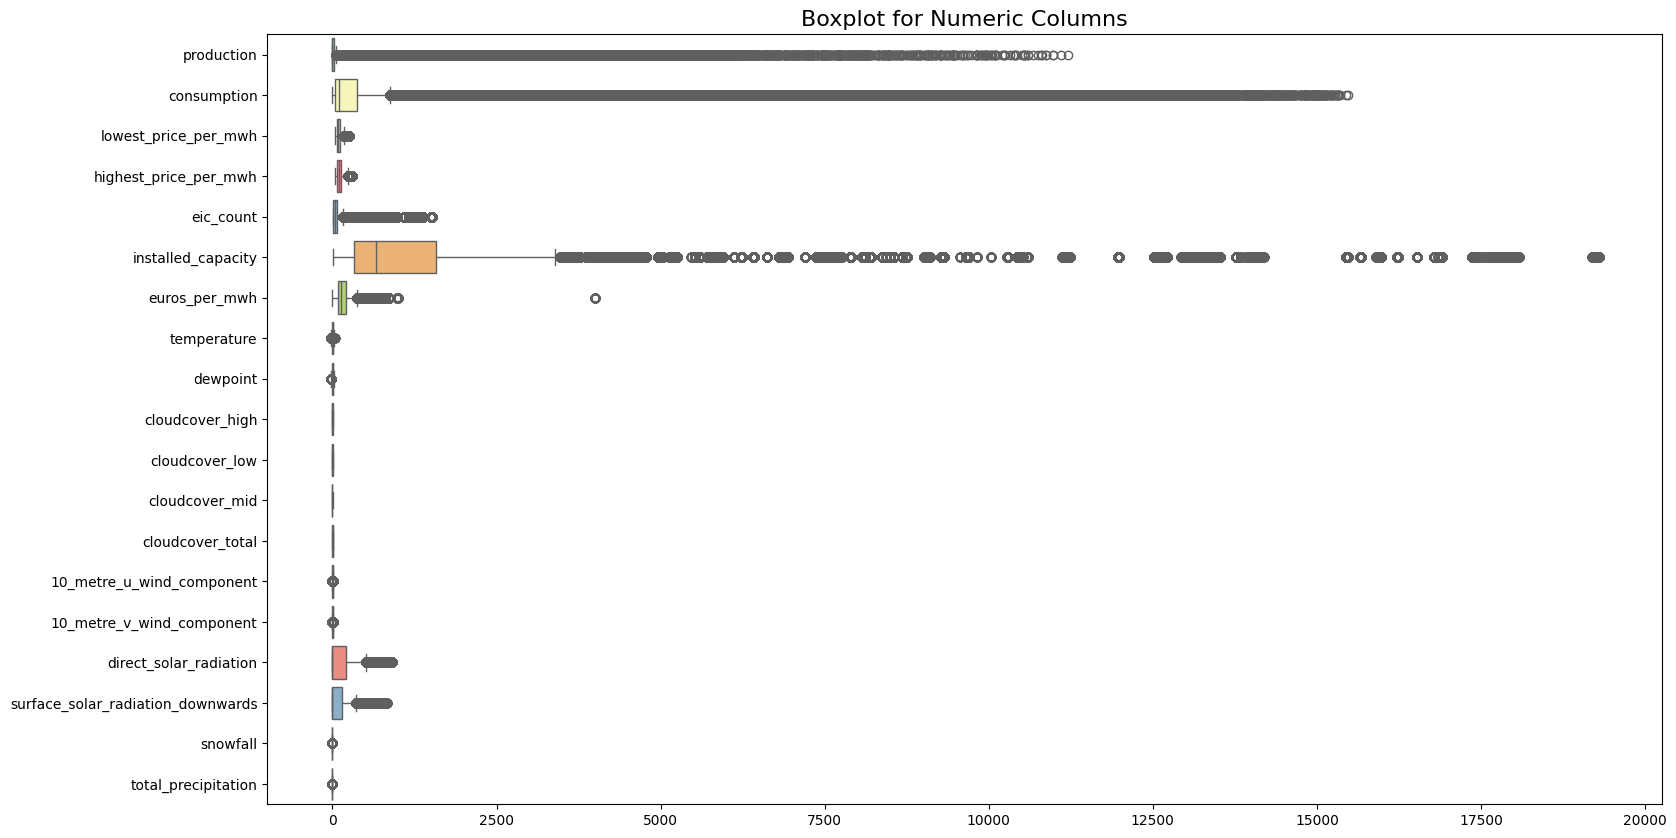

In [ ]:

# Plot the log-transformed boxplot
plt.figure(figsize=(18, 10))
sns.boxplot(data=df_non_nan[numeric_columns], orient='h', palette="Set3")
plt.title("Boxplot for Numeric Columns", fontsize=16)
plt.show()

<ipython-input-41-1b5b0d351e47>:2: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.



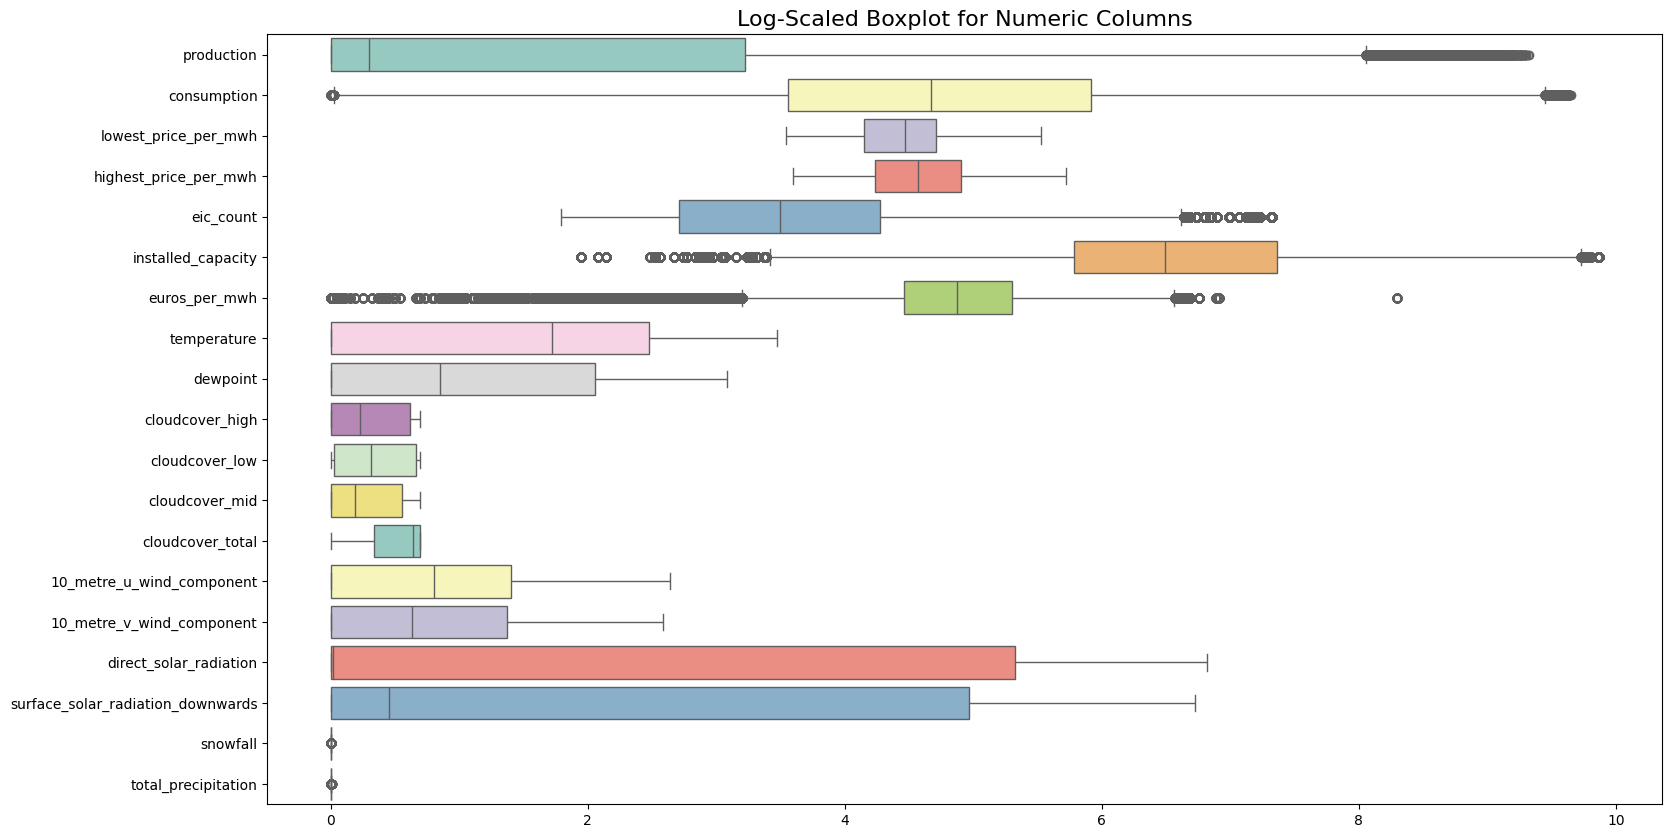

In [ ]:

# Apply log transformation to columns to reduce the impact of extreme outliers
df_log = df_non_nan[numeric_columns].applymap(lambda x: np.log1p(x) if x > 0 else 0)

# Plot the log-transformed boxplot
plt.figure(figsize=(18, 10))
sns.boxplot(data=df_log, orient='h', palette="Set3")
plt.title("Log-Scaled Boxplot for Numeric Columns", fontsize=16)
plt.show()

### Handling Outliers using IQR

In [ ]:
df_log = df_non_nan.copy()
df_log[numeric_columns] = df_log[numeric_columns].applymap(lambda x: np.log1p(x) if x >= 0 else np.nan)

# Calculate IQR for each numeric column (after log transformation)
Q1 = df_log[numeric_columns].quantile(0.25)
Q3 = df_log[numeric_columns].quantile(0.75)
IQR = Q3 - Q1

# Define the range for outliers (1.5 * IQR rule)
outlier_mask = ((df_log[numeric_columns] < (Q1 - 1.5 * IQR)) |
                (df_log[numeric_columns] > (Q3 + 1.5 * IQR)))

# Remove rows with outliers
df_cleaned = df_log[~outlier_mask.any(axis=1)]

# Print the number of rows before and after removing outliers
print(f"Original number of rows: {df_non_nan.shape[0]}")
print(f"Number of rows after removing outliers: {df_cleaned.shape[0]}")

<ipython-input-42-cad88250e248>:2: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.



Original number of rows: 979937
Number of rows after removing outliers: 635557


### Randomly selecting 2% data from cleaned data

It is essential to our dataset because it helps balance the need for sufficient data to capture the underlying patterns while managing the practical limitations of computation and memory.

In [ ]:
df_non_nan_half = df_cleaned.sample(frac=0.02, random_state=42)

In [ ]:
df_non_nan_half = df_non_nan_half.dropna()

In [ ]:
df_non_nan_half.shape

(3325, 28)

### Train Test Split

In [ ]:
features = ['county', 'is_business', 'product_type', 'lowest_price_per_mwh',
            'highest_price_per_mwh', 'eic_count', 'installed_capacity',
            'euros_per_mwh', 'temperature', 'dewpoint', 'cloudcover_high',
            'cloudcover_low', 'cloudcover_mid', 'cloudcover_total',
            '10_metre_u_wind_component', '10_metre_v_wind_component',
            'direct_solar_radiation', 'surface_solar_radiation_downwards',
            'snowfall', 'total_precipitation', 'day', 'month', 'year']

X = df_non_nan_half[features]
y_production = df_non_nan_half['production']
y_consumption = df_non_nan_half['consumption']

# Split data into training and testing sets for both production and consumption
X_train, X_test, y_train_prod, y_test_prod = train_test_split(X, y_production, test_size=0.2, random_state=42)
_, _, y_train_cons, y_test_cons = train_test_split(X, y_consumption, test_size=0.2, random_state=42)

### Feature Scaling

In [ ]:
# Initialize the scaler
scaler = StandardScaler()

# Fit and transform the training data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


### Baseline Gaussian Process Model with Scaled Data

In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.metrics import mean_squared_error

# Define the kernel (RBF) and GP model for production
kernel = C(1.0, (1e-4, 1e1)) * RBF(1.0, (1e-2, 1e1))
# kernel = C(1.0) * RBF(1.0)
gp_prod = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=1e-2)
gp_cons = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=1e-2)
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


# Train the GP model on scaled data for production
gp_prod.fit(X_train_scaled, y_train_prod)
gp_cons.fit(X_train_scaled, y_train_cons)

# Predict on the scaled test data for production and consumption
y_pred_prod, sigma_prod = gp_prod.predict(X_test_scaled, return_std=True)
y_pred_cons, sigma_cons = gp_cons.predict(X_test_scaled, return_std=True)

# Evaluate performance using Mean Squared Error
mse_prod = mean_squared_error(y_test_prod, y_pred_prod)
mse_cons = mean_squared_error(y_test_cons, y_pred_cons)

# Evaluate performance using Mean Squared Error
mae_prod = mean_absolute_error(y_test_prod, y_pred_prod)
mae_cons = mean_absolute_error(y_test_cons, y_pred_cons)

print(f"Production MSE: {mse_prod}")
print(f"Consumption MSE: {mse_cons}")

print(f"Production MAE: {mae_prod}")
print(f"Consumption MAE: {mae_cons}")


Production MSE: 0.5669943184980326
Consumption MSE: 0.5959308395613147
Production MAE: 0.5325504408712528
Consumption MAE: 0.5666945216774377


### Hyperparameter Optimization

In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

# Define the kernel for the Gaussian Process
kernel = C(1.0, (1e-4, 1e1)) * RBF(1.0, (1e-2, 1e1))

# Create a Gaussian Process Regressor for production prediction
gp_prod = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=5)
# Create a Gaussian Process Regressor for consumption prediction
gp_cons = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=5)

# Define the hyperparameter grid for cross-validation
param_grid = {
    'kernel__k2__length_scale': [0.1, 1.0, 10.0],
    'alpha': [0.05, 0.01, 0.1]
}

# Perform GridSearchCV for production prediction
grid_search_prod = GridSearchCV(gp_prod, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_prod.fit(X_train_scaled, y_train_prod)
# Perform GridSearchCV for consumption prediction
grid_search_cons = GridSearchCV(gp_cons, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_cons.fit(X_train_scaled, y_train_cons)


# Get the best model and parameters
best_gp_prod = grid_search_prod.best_estimator_
print("Best hyperparameters for production (CV):", grid_search_prod.best_params_)
# Get the best model and parameters for consumption
best_gp_cons = grid_search_cons.best_estimator_
print("Best hyperparameters for consumption (CV):", grid_search_cons.best_params_)


# Predictions and evaluation
y_pred_prod, sigma_prod = best_gp_prod.predict(X_test_scaled, return_std=True)
mse_prod = mean_squared_error(y_test_prod, y_pred_prod)
print(f"Production MSE (CV optimized): {mse_prod}")
# Predictions and evaluation
y_pred_cons, sigma_cons = best_gp_cons.predict(X_test_scaled, return_std=True)
mse_cons = mean_squared_error(y_test_cons, y_pred_cons)
print(f"Consumption MSE (CV optimized): {mse_cons}")

# Evaluate performance using Mean Squared Error
mae_prod = mean_absolute_error(y_test_prod, y_pred_prod)
mae_cons = mean_absolute_error(y_test_cons, y_pred_cons)

print(f"Production MAE: {mae_prod}")
print(f"Consumption MAE: {mae_cons}")

Best hyperparameters for production (CV): {'alpha': 0.1, 'kernel__k2__length_scale': 0.1}
Best hyperparameters for consumption (CV): {'alpha': 0.1, 'kernel__k2__length_scale': 0.1}
Production MSE (CV optimized): 0.43743152615097985
Consumption MSE (CV optimized): 0.4183837415186621
Production MAE: 0.4471494690862026
Consumption MAE: 0.47472870298014236


### Bayseain Optimization

In [ ]:
from skopt import gp_minimize
from skopt.space import Real

# Define the objective function for production
def objective_prod(params):
    length_scale, alpha = params
    kernel = C(1.0) * RBF(length_scale)
    gp_prod = GaussianProcessRegressor(kernel=kernel, alpha=alpha)
    gp_prod.fit(X_train_scaled, y_train_prod)
    y_pred_prod, _ = gp_prod.predict(X_test_scaled, return_std=True)
    return mean_squared_error(y_test_prod, y_pred_prod)

# Define the objective function for consumption
def objective_cons(params):
    length_scale, alpha = params
    kernel = C(1.0) * RBF(length_scale)
    gp_cons = GaussianProcessRegressor(kernel=kernel, alpha=alpha)
    gp_cons.fit(X_train_scaled, y_train_cons)
    y_pred_cons, _ = gp_cons.predict(X_test_scaled, return_std=True)
    return mean_squared_error(y_test_cons, y_pred_cons)

# Define search space for Bayesian optimization
space = [
    Real(1e-2, 1e1, name='length_scale'),
    Real(1e-4, 1e-1, name='alpha')
]

# Perform Bayesian optimization
res_prod = gp_minimize(objective_prod, space, n_calls=30, random_state=42)
res_cons = gp_minimize(objective_cons, space, n_calls=30, random_state=42)

print(f"Best hyperparameters for Production: {res_prod.x}")
print(f"Best MSE for Production: {res_prod.fun}")
print(f"Best hyperparameters for Consumption: {res_cons.x}")
print(f"Best MSE for Consumption: {res_cons.fun}")


/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning:

The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.

/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning:

The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.

/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning:

The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.

/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning:

The optimal value found for dimension 0 

Best hyperparameters for Production: [9.815236117950358, 0.07243046200561976]
Best MSE for Production: 0.4717120866814193
Best hyperparameters for Consumption: [8.831233809883027, 0.08392367258841306]
Best MSE for Consumption: 0.4389254573233709


### Kernel Function Exploration

In [ ]:
# Matern kernel for production and consumption
matern_kernel = C(1.0) * Matern(length_scale=1.0, nu=1.5)
gp_matern_prod = GaussianProcessRegressor(kernel=matern_kernel, n_restarts_optimizer=10, alpha=1e-2)
gp_matern_cons = GaussianProcessRegressor(kernel=matern_kernel, n_restarts_optimizer=10, alpha=1e-2)

# Periodic kernel
periodic_kernel = C(1.0) * ExpSineSquared(length_scale=1.0, periodicity=1.0)
gp_periodic_prod = GaussianProcessRegressor(kernel=periodic_kernel, n_restarts_optimizer=10, alpha=1e-2)
gp_periodic_cons = GaussianProcessRegressor(kernel=periodic_kernel, n_restarts_optimizer=10, alpha=1e-2)

# Train and predict for production using Matern
gp_matern_prod.fit(X_train_scaled, y_train_prod)
y_pred_matern_prod, sigma_matern_prod = gp_matern_prod.predict(X_test_scaled, return_std=True)

# Train and predict for consumption using Matern
gp_matern_cons.fit(X_train_scaled, y_train_cons)
y_pred_matern_cons, sigma_matern_cons = gp_matern_cons.predict(X_test_scaled, return_std=True)

# Train and predict for production using Periodic kernel
gp_periodic_prod.fit(X_train_scaled, y_train_prod)
y_pred_periodic_prod, sigma_periodic_prod = gp_periodic_prod.predict(X_test_scaled, return_std=True)

# Train and predict for consumption using Periodic kernel
gp_periodic_cons.fit(X_train_scaled, y_train_cons)
y_pred_periodic_cons, sigma_periodic_cons = gp_periodic_cons.predict(X_test_scaled, return_std=True)


/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/_gpr.py:659: ConvergenceWarning:

lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



### Model Evaluation

In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Calculate RMSE for each kernel on production and consumption
rmse_rbf_prod = np.sqrt(mse_prod)
rmse_rbf_cons = np.sqrt(mse_cons)

rmse_matern_prod = np.sqrt(mean_squared_error(y_test_prod, y_pred_matern_prod))
rmse_matern_cons = np.sqrt(mean_squared_error(y_test_cons, y_pred_matern_cons))

rmse_periodic_prod = np.sqrt(mean_squared_error(y_test_prod, y_pred_periodic_prod))
rmse_periodic_cons = np.sqrt(mean_squared_error(y_test_cons, y_pred_periodic_cons))

# Print the RMSE for comparison
print(f"RMSE for Production (RBF Kernel): {rmse_rbf_prod}")
print(f"RMSE for Consumption (RBF Kernel): {rmse_rbf_cons}")

print(f"RMSE for Production (Matern Kernel): {rmse_matern_prod}")
print(f"RMSE for Consumption (Matern Kernel): {rmse_matern_cons}")

print(f"RMSE for Production (Periodic Kernel): {rmse_periodic_prod}")
print(f"RMSE for Consumption (Periodic Kernel): {rmse_periodic_cons}")

# Select the best model based on RMSE
best_rmse_prod = min(rmse_rbf_prod, rmse_matern_prod, rmse_periodic_prod)
best_rmse_cons = min(rmse_rbf_cons, rmse_matern_cons, rmse_periodic_cons)

print(f"Best RMSE for Production: {best_rmse_prod}")
print(f"Best RMSE for Consumption: {best_rmse_cons}")


RMSE for Production (RBF Kernel): 0.6613860643761553
RMSE for Consumption (RBF Kernel): 0.6468258973778509
RMSE for Production (Matern Kernel): 0.6551902982968163
RMSE for Consumption (Matern Kernel): 0.6012683052800459
RMSE for Production (Periodic Kernel): 3.013001256193543
RMSE for Consumption (Periodic Kernel): 0.7719617152701784
Best RMSE for Production: 0.6551902982968163
Best RMSE for Consumption: 0.6012683052800459


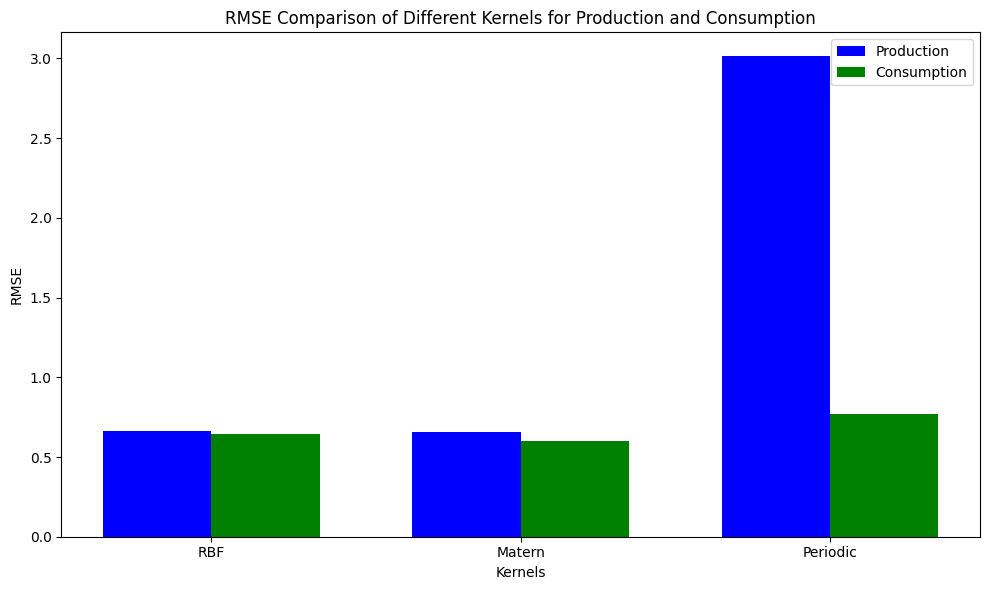

In [ ]:
import matplotlib.pyplot as plt

# RMSE values for plotting
kernels = ['RBF', 'Matern', 'Periodic']
rmse_prod = [rmse_rbf_prod, rmse_matern_prod, rmse_periodic_prod]
rmse_cons = [rmse_rbf_cons, rmse_matern_cons, rmse_periodic_cons]

# Set up the bar plot
bar_width = 0.35
index = np.arange(len(kernels))

fig, ax = plt.subplots(figsize=(10, 6))

# Create bars for production and consumption
bars_prod = ax.bar(index, rmse_prod, bar_width, label='Production', color='b')
bars_cons = ax.bar(index + bar_width, rmse_cons, bar_width, label='Consumption', color='g')

# Add labels and title
ax.set_xlabel('Kernels')
ax.set_ylabel('RMSE')
ax.set_title('RMSE Comparison of Different Kernels for Production and Consumption')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(kernels)
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()
